# **Renewable Energy and Sustainability**

In [5]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import warnings
import os
import json
import time
from tqdm import tqdm
import pycountry
from concurrent.futures import ThreadPoolExecutor
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore')

# Change chart types to vectors for better image quality
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

# Set chart size and theme
sns.set(rc = {"figure.figsize": (9, 5)}, style = "white")

## **1. How has global renewable energy adoption changed over the past two decades?**

Over the last two decades, the use of renewable energy worldwide has grown significantly, with notable increases in solar, wind, hydropower, and other sources like bioenergy. Solar power, in particular, has expanded rapidly, moving from minimal levels to a significant share of energy production, thanks to advances in technology and lower costs. Wind energy has also grown steadily, becoming an increasingly important part of the global energy mix. In contrast, hydropower has seen more gradual growth, likely due to geographic and infrastructure limitations, but it remains a major source of renewable energy. Meanwhile, other renewables, including bioenergy, have also shown consistent growth, reflecting a broader shift towards diverse clean energy options. Overall, these trends suggest a strong global movement towards renewable energy, driven by advancements in technology, supportive policies, and rising concerns about climate change.

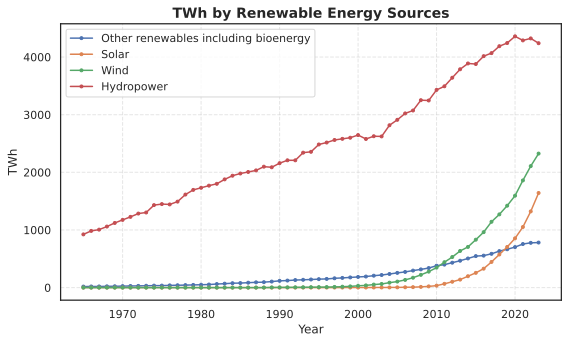

In [6]:
df = pd.read_csv("https://ourworldindata.org/grapher/modern-renewable-energy-consumption.csv?v=1&csvType=filtered&useColumnShortNames=true",
                 storage_options = {"User-Agent": "Our World In Data data fetch/1.0"})

df = df.rename(columns = {
    "other_renewables_electricity_generation_twh": "Other",
    "solar_electricity_generation_twh": "Solar",
    "wind_electricity_generation_twh": "Wind",
    "hydro_electricity_generation_twh": "Hydro"
})

df[["Other", "Solar", "Wind", "Hydro"]] = df[["Other", "Solar", "Wind", "Hydro"]].apply(pd.to_numeric, errors = "coerce")

grouped_df = df.groupby("Year").sum()
years = grouped_df.index

plt.plot(grouped_df.index, grouped_df["Other"], label = "Other renewables including bioenergy", marker = ".")
plt.plot(grouped_df.index, grouped_df["Solar"], label = "Solar", marker = ".")
plt.plot(grouped_df.index, grouped_df["Wind"], label = "Wind", marker = ".")
plt.plot(grouped_df.index, grouped_df["Hydro"], label = "Hydropower", marker = ".")

plt.xlabel("Year")
plt.ylabel("TWh")
plt.title("TWh by Renewable Energy Sources", fontsize = 14, weight = "bold")
plt.legend()
plt.grid(True, linestyle = "--", alpha = 0.5)

plt.show()

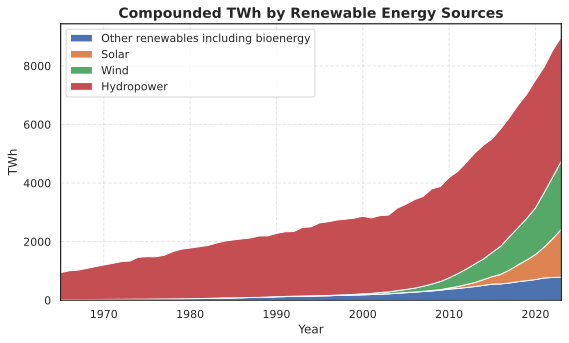

In [7]:
sources = ["Other", "Solar", "Wind", "Hydro"]
energy_data = grouped_df[sources]

plt.stackplot(years, energy_data.T, labels = ["Other renewables including bioenergy", "Solar", "Wind", "Hydropower"])

plt.xlabel("Year")
plt.ylabel("TWh")
plt.title("Compounded TWh by Renewable Energy Sources", fontsize = 14, weight = "bold")
plt.grid(True, linestyle = "--", alpha = 0.5)
plt.legend()
plt.xlim(years.min(), years.max())

plt.show()

## **2. Which countries generate the highest percentage of their electricity from renewables?**

Countries in South America stand out distinctly due to their impressive reliance on renewable sources for electricity. Brazil, in particular, emerges as a major country notable for consistently generating a substantial portion (often over 75%) of its electricity from renewable sources, primarily thanks to its expansive hydropower infrastructure. Similarly, Colombia and Venezuela demonstrate strong commitments to renewables, frequently surpassing the 60% mark, reinforcing the region's leadership in renewable energy adoption relative to other populous countries around the globe.

Elsewhere, significant renewable electricity percentages are evident in some major European nations, particularly Norway and Iceland, whose renewable energy contributions routinely approach or reach complete reliance. While smaller in population, these countries are noteworthy due to their consistently high renewable energy usage, driven predominantly by hydropower and geothermal resources, respectively. Conversely, the visualization reveals that major global economies such as China, the United States, and India, despite making recent strides, have noticeably lower percentages, highlighting a stark contrast with South American and European counterparts.

In [46]:
df = pd.read_csv("https://ourworldindata.org/grapher/share-electricity-renewables.csv?v=1&csvType=full&useColumnShortNames=true",
                 storage_options = {"User-Agent": "Our World In Data data fetch/1.0"})

df = df.dropna(subset = ["Code"])
df = df.rename(columns = {"renewable_share_of_electricity__pct": "Renewable Share (%)"})
df["Year"] = df["Year"].astype(int)
df = df.sort_values(by = ["Year", "Entity"])

min_value = df["Renewable Share (%)"].min()
max_value = df["Renewable Share (%)"].max()

fig = px.choropleth(df,
                    locations = "Code",
                    color = "Renewable Share (%)",
                    hover_name = "Entity",
                    animation_frame = "Year",
                    animation_group = "Entity",
                    color_continuous_scale = px.colors.sequential.Greens,
                    range_color = [min_value, max_value],
                    title = "Electricity Production from Renewables by Country")

fig.update_geos(projection_type = "natural earth")
fig.update_layout(margin = {"r":0,"t":40,"l":0,"b":0})
fig.write_html("Electricity_Production_from_Renewables_by_Country.html")
fig.show()

## **3. How does the share of renewables in total energy consumption vary across different regions?**

The share of renewables in total energy consumption varies significantly among regions, highlighting clear leaders and those struggling behind in renewable energy adoption. Oceania notably stands out with a consistently high share of renewable energy, reflecting strong utilization of resources like hydropower and geothermal energy, particularly in nations such as New Zealand. Europe also demonstrates steady growth, though it trails behind Oceania in overall performance. South America maintains a robust and stable reliance on renewables, largely driven by hydropower, placing it among the stronger regions. Meanwhile, North America and Asia exhibit noticeably lower renewable energy percentages, indicating continued reliance on fossil fuels despite gradual improvements.

The bar chart clearly indicates South America leading significantly in renewable energy consumption, with the highest overall regional average, likely driven by extensive hydropower infrastructure. Oceania follows, displaying impressive renewable energy adoption, though not matching South America's level. North America and Europe come next, nearly tied, with North America holding only a slight edge over Europe. Both regions demonstrate strong renewable energy usage but remain notably behind South America and Oceania. Finally, Asia trails all these regions considerably, suggesting continued heavy reliance on traditional, non-renewable energy sources.

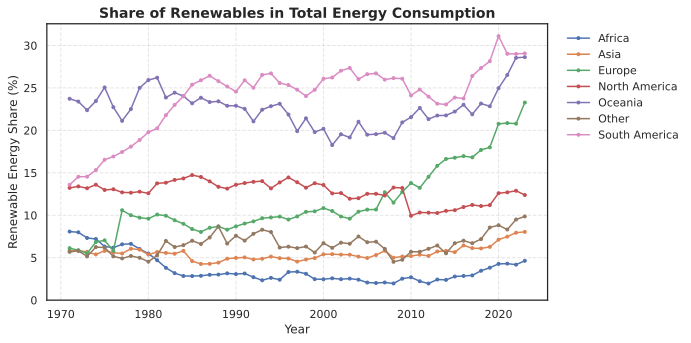

In [9]:
df = pd.read_csv("https://ourworldindata.org/grapher/renewable-share-energy.csv?v=1&csvType=full&useColumnShortNames=true",
                 storage_options = {"User-Agent": "Our World In Data data fetch/1.0"})

df = df.rename(columns = {
    "Entity": "Region",
    "renewables__pct_equivalent_primary_energy": "Renewable_Energy_Share"
})

df_countries = df.dropna(subset = ["Code"]).copy()
df_countries = df_countries[df_countries['Year'] > 1970]

region_mapping = {
    "Africa": ["DZA", "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", "CAF", "TCD", "COM", "COG", "COD", "DJI", "EGY",
               "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA", "GIN", "GNB", "CIV", "KEN", "LSO", "LBR", "LBY", "MDG",
               "MWI", "MLI", "MRT", "MUS", "MAR", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", "SEN", "SYC", "SLE", "SOM",
               "ZAF", "SSD", "SDN", "TZA", "TGO", "TUN", "UGA", "ZMB", "ZWE"],
    "Asia": ["AFG", "ARM", "AZE", "BHR", "BGD", "BTN", "BRN", "KHM", "CHN", "GEO", "IND", "IDN", "IRN", "IRQ", "ISR",
             "JPN", "JOR", "KAZ", "PRK", "KOR", "KWT", "KGZ", "LAO", "LBN", "MYS", "MDV", "MNG", "MMR", "NPL", "OMN",
             "PAK", "PSE", "PHL", "QAT", "SAU", "SGP", "LKA", "SYR", "TJK", "THA", "TLS", "TKM", "ARE", "UZB", "VNM", "YEM"],
    "Europe": ["ALB", "AUT", "BLR", "BEL", "BIH", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA", "DEU", "GRC",
               "HUN", "ISL", "IRL", "ITA", "XKX", "LVA", "LTU", "LUX", "MLT", "MDA", "MNE", "NLD", "MKD", "NOR", "POL",
               "PRT", "ROU", "RUS", "SRB", "SVK", "SVN", "ESP", "SWE", "CHE", "UKR", "GBR"],
    "North America": ["ATG", "BHS", "BRB", "BLZ", "CAN", "CRI", "CUB", "DMA", "DOM", "SLV", "GRD", "GTM", "HTI", "HND",
                      "JAM", "MEX", "NIC", "PAN", "KNA", "LCA", "VCT", "TTO", "USA"],
    "Oceania": ["AUS", "FJI", "KIR", "MHL", "FSM", "NRU", "NZL", "PLW", "PNG", "WSM", "SLB", "TON", "TUV", "VUT"],
    "South America": ["ARG", "BOL", "BRA", "CHL", "COL", "ECU", "GUY", "PRY", "PER", "SUR", "URY", "VEN"]
}

def get_region(code):
    for region, countries in region_mapping.items():
        if code in countries:
            return region
    return "Other"

df_countries.loc[:, "Region"] = df_countries["Code"].apply(get_region)

df_regional_summary = df_countries.groupby(["Region", "Year"], as_index = False)["Renewable_Energy_Share"].mean()

for region in df_regional_summary["Region"].unique():
    regional_data = df_regional_summary[df_regional_summary["Region"] == region]
    plt.plot(regional_data["Year"], regional_data["Renewable_Energy_Share"], label = region, marker = ".")

plt.title("Share of Renewables in Total Energy Consumption", fontsize = 14, weight = "bold")
plt.xlabel("Year")
plt.ylabel("Renewable Energy Share (%)")
plt.grid(True, linestyle = "--", alpha = 0.5)
plt.legend(bbox_to_anchor=(1.02, 1), frameon = False)
plt.ylim(0, None)

plt.show()

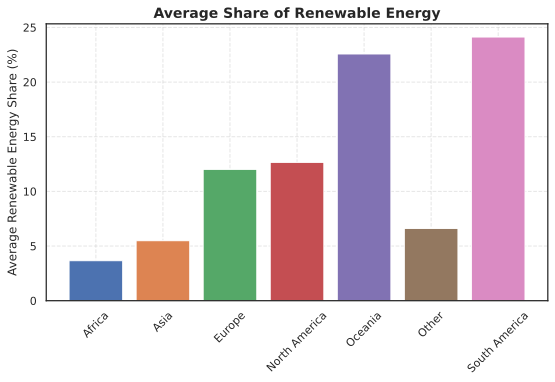

In [10]:
def assign_region(code):
    for region, countries in region_mapping.items():
        if code in countries:
            return region
    return "Other"

df_countries["Region"] = df_countries["Code"].apply(assign_region)

regional_totals = df_countries.groupby("Region", as_index = False)["Renewable_Energy_Share"].mean()

plt.bar(regional_totals["Region"], regional_totals["Renewable_Energy_Share"], color = sns.color_palette(n_colors = len(regional_totals)))
plt.title("Average Share of Renewable Energy", fontsize = 14, weight = "bold")
plt.ylabel("Average Renewable Energy Share (%)")
plt.grid(True, linestyle = "--", alpha = 0.5)
plt.xticks(rotation = 45)

plt.show()

## **4. What regions have the highest potential for solar and wind energy production?**

The full-region analysis using NASA POWER climatology data and complete country lists reveals distinct regional strengths in renewable energy potential. Africa and Oceania show the highest average daily solar irradiance (~5.6 and 5.4 kWh/m² respectively), while Oceania and North America lead in wind speed (both above 4.5 m/s). Europe has relatively low solar potential, but compensates with moderate wind capacity. These insights align well with regional energy deployment trends and justify further investment tailoring.

The highest solar radiation values are observed in countries located in arid subtropical belts—mainly in Africa and the Middle East. Sudan, Yemen, Somalia, Chad, Niger and Mauritania all have GHIs above 6.5 kWh/m²/day, making them ideal for large-scale solar generation. Also noteworthy are the high values of Chile and Australia, confirming their sustained leadership in solar power.

Wind potential is greatest in island and coastal countries: St. Lucia, Barbados, Fiji, Dominica, Grenada, and Barbados all show average annual wind speeds above 6.8 m/s, making them particularly promising for wind energy. Also in the top are the Marshall Islands, Iceland and Cape Verde, confirming the importance of geographical location (oceanic influence, mountain ranges, narrow wind passages).

#### **4.1. Parsing**

In [35]:
# Set region_mapping
region_mapping = {
    "Africa": ["DZA", "AGO", "BEN", "BWA", "BFA", "BDI", "CPV", "CMR", "CAF", "TCD", "COM", "COG", "COD", "DJI", "EGY",
               "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA", "GIN", "GNB", "CIV", "KEN", "LSO", "LBR", "LBY", "MDG",
               "MWI", "MLI", "MRT", "MUS", "MAR", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", "SEN", "SYC", "SLE", "SOM",
               "ZAF", "SSD", "SDN", "TZA", "TGO", "TUN", "UGA", "ZMB", "ZWE"],
    "Asia": ["AFG", "ARM", "AZE", "BHR", "BGD", "BTN", "BRN", "KHM", "CHN", "GEO", "IND", "IDN", "IRN", "IRQ", "ISR",
             "JPN", "JOR", "KAZ", "PRK", "KOR", "KWT", "KGZ", "LAO", "LBN", "MYS", "MDV", "MNG", "MMR", "NPL", "OMN",
             "PAK", "PSE", "PHL", "QAT", "SAU", "SGP", "LKA", "SYR", "TJK", "THA", "TLS", "TKM", "ARE", "UZB", "VNM", "YEM"],
    "Europe": ["ALB", "AUT", "BLR", "BEL", "BIH", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA", "DEU", "GRC",
               "HUN", "ISL", "IRL", "ITA", "XKX", "LVA", "LTU", "LUX", "MLT", "MDA", "MNE", "NLD", "MKD", "NOR", "POL",
               "PRT", "ROU", "RUS", "SRB", "SVK", "SVN", "ESP", "SWE", "CHE", "UKR", "GBR"],
    "North America": ["ATG", "BHS", "BRB", "BLZ", "CAN", "CRI", "CUB", "DMA", "DOM", "SLV", "GRD", "GTM", "HTI", "HND",
                      "JAM", "MEX", "NIC", "PAN", "KNA", "LCA", "VCT", "TTO", "USA"],
    "Oceania": ["AUS", "FJI", "KIR", "MHL", "FSM", "NRU", "NZL", "PLW", "PNG", "WSM", "SLB", "TON", "TUV", "VUT"],
    "South America": ["ARG", "BOL", "BRA", "CHL", "COL", "ECU", "GUY", "PRY", "PER", "SUR", "URY", "VEN"]
}

parameters = ["ALLSKY_SFC_SW_DWN", "WS10M"]
param_names = {"ALLSKY_SFC_SW_DWN": "Solar", "WS10M": "Wind"}

# Files for the cache
coords_cache_file = "coords_cache.json"
nasa_cache_file = "nasa_cache.json"

# Load and create a coordinate cache
if os.path.exists(coords_cache_file):
    with open(coords_cache_file, "r") as f:
        coords_cache = json.load(f)
else:
    coords_cache = {}

# Load and create a NASA data cache
if os.path.exists(nasa_cache_file):
    with open(nasa_cache_file, "r") as f:
        nasa_cache = json.load(f)
else:
    nasa_cache = {}

# Function to get ISO3 coordinates via restcountries API with caching
def get_coords_from_iso3(iso3):
    if iso3 in coords_cache:
        return coords_cache[iso3]["lat"], coords_cache[iso3]["lon"]
    try:
        url = f"https://restcountries.com/v3.1/alpha/{iso3}"
        resp = requests.get(url)
        data = resp.json()
        latlng = data[0]["latlng"]  # [lat, lon]
        coords_cache[iso3] = {"lat": latlng[0], "lon": latlng[1]}
        # Refresh the cache
        with open(coords_cache_file, "w") as f:
            json.dump(coords_cache, f)
        return latlng[0], latlng[1]
    except Exception as e:
        print(f"\nError obtaining coordinates for{iso3}: {e}")
        return None, None

# Function to retrieve NASA POWER coordinate data with caching
def get_nasa_data(lat, lon, parameters):
    key = f"{lat:.4f}_{lon:.4f}_{'_'.join(parameters)}"
    if key in nasa_cache:
        return nasa_cache[key]
    url = f"https://power.larc.nasa.gov/api/temporal/climatology/point?parameters={','.join(parameters)}&community=RE&longitude={lon}&latitude={lat}&format=JSON"
    try:
        response = requests.get(url)
        data = response.json()
        nasa_cache[key] = data
        # Refresh the cache
        with open(nasa_cache_file, "w") as f:
            json.dump(nasa_cache, f)
        return data
    except Exception as e:
        print(f"\nNASA POWER request error for {lat}, {lon}: {e}")
        return None

results = []

# Count the total number of countries for the progress bar
total_countries = sum(len(countries) for countries in region_mapping.values())
progress_bar = tqdm(total=total_countries, desc="Country Processing", unit="country")

# Loop by region and country
for region, countries in region_mapping.items():
    solar_vals = []
    wind_vals = []

    for code in countries:
        lat, lon = get_coords_from_iso3(code)
        progress_bar.update(1)
        if lat is None or lon is None:
            continue

        data = get_nasa_data(lat, lon, parameters)
        if data is None:
            continue

        try:
            solar = data['properties']['parameter']["ALLSKY_SFC_SW_DWN"]
            wind = data['properties']['parameter']["WS10M"]
            # Calculate the monthly average
            solar_avg = sum(solar.values()) / len(solar)
            wind_avg = sum(wind.values()) / len(wind)
            solar_vals.append(solar_avg)
            wind_vals.append(wind_avg)
        except Exception as e:
            print(f"Data processing error forNo data to visualize. {code}: {e}")
            continue

    # For a region, calculate the average for all countries
    if solar_vals and wind_vals:
        results.append({"Region": region, "Type": "Solar", "Value": sum(solar_vals) / len(solar_vals)})
        results.append({"Region": region, "Type": "Wind", "Value": sum(wind_vals) / len(wind_vals)})

progress_bar.close()
print(f"\nDone. ✅ {len(nasa_cache)} locations cached to 'nasa_cache.json'.")

Country Processing: 100%|██████████| 190/190 [00:00<00:00, 1121.47country/s]


Error obtaining coordinates forXKX: 0

Done. ✅ 189 locations cached to 'nasa_cache.json'.


#### **4.2. Plotting**

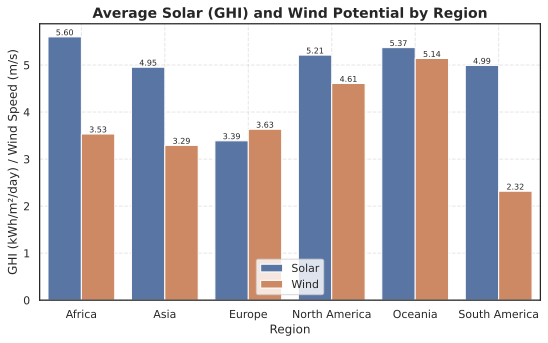

In [36]:
df = pd.DataFrame(results)
ax = sns.barplot(data = df, x = "Region", y = "Value", hue = "Type")
plt.title("Average Solar (GHI) and Wind Potential by Region", fontsize = 14, weight = "bold")
plt.ylabel("GHI (kWh/m²/day) / Wind Speed (m/s)")
plt.grid(True, linestyle = "--", alpha = 0.5)

for container in ax.containers:
  ax.bar_label(container, fmt = "%.2f", fontsize = 8)

legend = plt.legend(loc = "lower center")

plt.show()

In [47]:
with open("coords_cache.json") as f:
    coords_data = json.load(f)

with open("nasa_cache.json") as f:
    nasa_data = json.load(f)

coord_to_iso = {}
for iso3, val in coords_data.items():
    lat = round(float(val["lat"]), 4)
    lon = round(float(val["lon"]), 4)
    coord_key = f"{lat:.4f}_{lon:.4f}"
    coord_to_iso[coord_key] = iso3

records = []
for key, val in nasa_data.items():
    try:
        parts = key.split("_")
        lat, lon = float(parts[0]), float(parts[1])
        coord_key = f"{lat:.4f}_{lon:.4f}"
        iso3 = coord_to_iso.get(coord_key, None)
        if not iso3:
            continue

        ghi = val["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"]["ANN"]
        wind = val["properties"]["parameter"]["WS10M"]["ANN"]

        name = pycountry.countries.get(alpha_3=iso3).name if pycountry.countries.get(alpha_3=iso3) else iso3

        records.append({
            "ISO3": iso3,
            "Country": name,
            "GHI": ghi,
            "Wind": wind
        })
    except Exception as e:
        print(f"Ошибка обработки {key}: {e}")
        continue

df = pd.DataFrame(records)
df = df.sort_values(by="GHI", ascending=False).reset_index(drop=True)

# Solar
fig1 = px.choropleth(df, locations = "ISO3", color = "GHI",
                    color_continuous_scale = "YlOrRd",
                    title = "Global Solar Potential (GHI, kWh/m²/day)",
                    labels = {"GHI": "Solar Potential"},
                    hover_name = "Country")
fig1.update_geos(projection_type = "natural earth")
fig1.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig1.write_html("Global_Solar_Potential_GHI_kWh_per_m2_per_day.html")

fig1.show()

# Wind
fig2 = px.choropleth(df, locations = "ISO3", color = "Wind",
                    color_continuous_scale = "Blues",
                    title = "Global Wind Speed Potential (m/s)",
                    labels = {"Wind": "Wind Speed"},
                    hover_name = "Country")
fig2.update_geos(projection_type = "natural earth")
fig2.update_layout(margin = {"r":0,"t":40,"l":0,"b":0})
fig2.write_html("Global_Wind_Speed_Potential_mps.html")
fig2.show()


## **5. How do seasonal variations affect affect solar and wind energy generation?**

The seasonal variation of solar potential across the top-performing countries demonstrates distinct geographical patterns. Equatorial and northern hemisphere countries (e.g., Sudan, Yemen, Chad) exhibit peak irradiance between April and July, consistent with longer daylight and clearer skies. In contrast, countries in the southern hemisphere, such as Chile and Australia, show a shifted seasonality, with solar potential peaking during December–January

The seasonal variation of wind speed across the top-performing countries reflects clear regional patterns. Caribbean nations (e.g., Saint Lucia, Barbados) show stable year-round wind conditions with slight dips in late summer. Southern hemisphere countries like Fiji and Mauritius exhibit a mid-year slowdown, while northern regions such as Iceland peak during winter.

These observations emphasize the importance of regional adaptation in planning solar and wind energy systems, and in developing energy storage strategies.

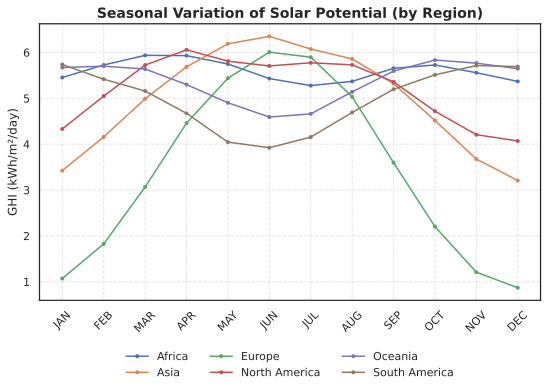

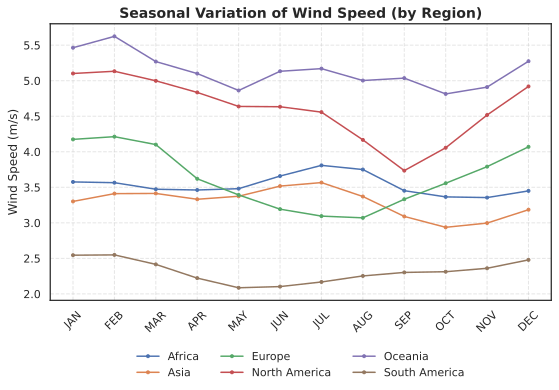

In [38]:
with open("coords_cache.json") as f:
    coords_data = json.load(f)
with open("nasa_cache.json") as f:
    nasa_data = json.load(f)

months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
solar_data = {}
wind_data = {}

for region, countries in region_mapping.items():
    monthly_solar = {m: [] for m in months}
    monthly_wind = {m: [] for m in months}

    for code in countries:
        coords = coords_data.get(code)
        if not coords:
            continue
        lat = f"{coords['lat']:.4f}"
        lon = f"{coords['lon']:.4f}"
        key = f"{lat}_{lon}_ALLSKY_SFC_SW_DWN_WS10M"
        data = nasa_data.get(key)
        if not data:
            continue
        solar = data["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"]
        wind = data["properties"]["parameter"]["WS10M"]
        for m in months:
            monthly_solar[m].append(solar[m])
            monthly_wind[m].append(wind[m])

    solar_data[region] = [sum(monthly_solar[m])/len(monthly_solar[m]) for m in months]
    wind_data[region] = [sum(monthly_wind[m])/len(monthly_wind[m]) for m in months]

solar_df = pd.DataFrame(solar_data, index=months)
wind_df = pd.DataFrame(wind_data, index=months)

def line_plot(df, title, ylabel):
    for i, region in enumerate(df.columns):
        plt.plot(df.index, df[region], marker = '.', label = region)
    plt.title(title, fontsize = 14, weight = "bold")
    plt.ylabel(ylabel)
    plt.xticks(rotation = 45)
    plt.grid(True, linestyle = "--", alpha = 0.5)
    plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.15), ncol = 3, frameon=False)

    plt.show()

line_plot(solar_df, "Seasonal Variation of Solar Potential (by Region)", "GHI (kWh/m²/day)")
line_plot(wind_df, "Seasonal Variation of Wind Speed (by Region)", "Wind Speed (m/s)")

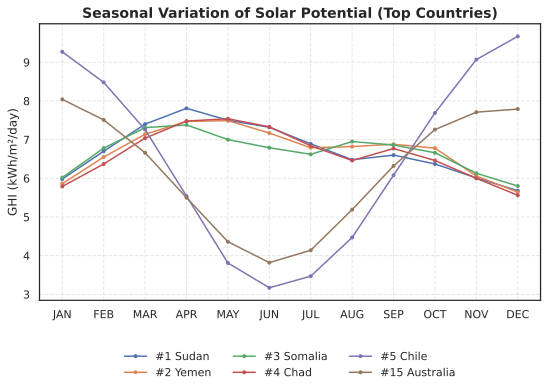

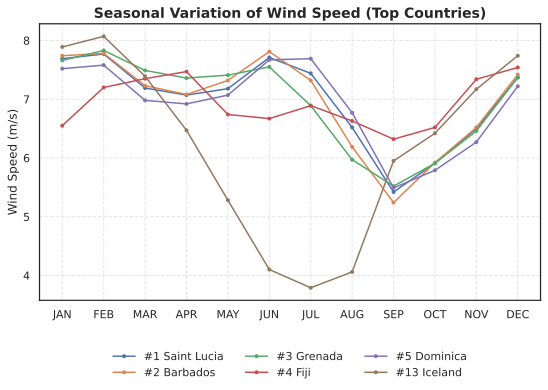

In [34]:
def extract_monthly_data(df, value_col, data_key):
    df = df.sort_values(by=value_col, ascending=False).reset_index(drop=True)
    selected = df.iloc[[0, 1, 2, 3, 4, 14 if value_col == "GHI" else 12]].copy()
    selected["Rank"] = selected.index + 1

    monthly_data = {}
    for _, row in selected.iterrows():
        iso3 = row["ISO3"]
        country = row["Country"]
        label = f"#{row['Rank']} {country}"
        lat = round(coords_data[iso3]["lat"], 4)
        lon = round(coords_data[iso3]["lon"], 4)
        key = f"{lat:.4f}_{lon:.4f}_ALLSKY_SFC_SW_DWN_WS10M"

        try:
            param = nasa_data[key]["properties"]["parameter"][data_key]
            monthly_data[label] = [param[month] for month in months]
        except:
            continue
    return pd.DataFrame(monthly_data, index = months)

def plot_seasonal(df, title, ylabel):
    for country in df.columns:
        plt.plot(months, df[country], marker = '.', label = country)
    plt.title(title, fontsize = 14, weight = "bold")
    plt.ylabel(ylabel)
    plt.legend( loc = 'upper center', bbox_to_anchor = (0.5, -0.15), ncol = 3, frameon = False)
    plt.grid(True, linestyle = "--", alpha = 0.5)
    plt.show()

ghi_df = extract_monthly_data(df, "GHI", "ALLSKY_SFC_SW_DWN")
plot_seasonal(ghi_df, "Seasonal Variation of Solar Potential (Top Countries)", "GHI (kWh/m²/day)")

wind_df = extract_monthly_data(df, "Wind", "WS10M")
plot_seasonal(wind_df, "Seasonal Variation of Wind Speed (Top Countries)", "Wind Speed (m/s)")

In [16]:
months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

df = df.sort_values(by = "GHI", ascending = False)
selected = df.iloc[[0,1,2,3,4,14]]
monthly_ghi = {}

for _, row in selected.iterrows():
    iso3 = row["ISO3"]
    country = row["Country"]
    rank = df[df["ISO3"] == iso3].index[0] + 1
    label = f"#{rank} {country}"

    lat = round(coords_data[iso3]["lat"], 4)
    lon = round(coords_data[iso3]["lon"], 4)
    key = f"{lat:.4f}_{lon:.4f}_ALLSKY_SFC_SW_DWN_WS10M"

    try:
        ghi_monthly = nasa_data[key]["properties"]["parameter"]["ALLSKY_SFC_SW_DWN"]
        monthly_ghi[label] = [ghi_monthly[month] for month in months]
    except:
        continue


plot_df = pd.DataFrame(monthly_ghi, index=months)

plot_df = plot_df.T

for country in plot_df.index:
    plt.plot(months, plot_df.loc[country], marker = '.', label = country)

plt.title("Seasonal Variation of Solar Potential (Top 5 Countries)", fontsize = 14, weight = "bold")
plt.xlabel("Month")
plt.ylabel("GHI (kWh/m²/day)")
plt.legend(title = "Country")
plt.grid(True, linestyle = "--", alpha = 0.5)
plt.show()

KeyError: 'GHI'

In [17]:
df = df.sort_values(by = "Wind", ascending = False).reset_index(drop = True)
selected = df.iloc[[0, 1, 2, 3, 7, 12]].copy()

selected["Rank"] = selected.index + 1

monthly_wind = {}

for _, row in selected.iterrows():
    iso3 = row["ISO3"]
    country = row["Country"]
    rank = row["Rank"]
    label = f"#{rank} {country}"

    lat = round(coords_data[iso3]["lat"], 4)
    lon = round(coords_data[iso3]["lon"], 4)
    key = f"{lat:.4f}_{lon:.4f}_ALLSKY_SFC_SW_DWN_WS10M"

    try:
        wind_monthly = nasa_data[key]["properties"]["parameter"]["WS10M"]
        monthly_wind[label] = [wind_monthly[month] for month in months]
    except:
        continue

plot_df = pd.DataFrame(monthly_wind, index = months)

for country in plot_df.columns:
    plt.plot(months, plot_df[country], marker = '.', label = country)

plt.title("Seasonal Variation of Wind Speed (Ranked Selection)", fontsize = 14, weight = "bold")
plt.xlabel("Month")
plt.ylabel("Wind Speed (m/s)")
plt.legend(title = "Country")
plt.grid(True, linestyle = "--", alpha = 0.5)
plt.show()

KeyError: 'Wind'

## **6. How does climate change impact the efficiency of renewable energy sources over time?**

The analysis of global solar radiation and wind speed trends from 2001 to 2022 reveals clear regional disparities in renewable energy potential, influenced by climate change. Solar radiation has remained relatively stable across most regions, with Africa and Asia continuing to show higher levels of irradiance, while Europe’s lower values reflect its more moderate climate. Wind speed, conversely, exhibits more variation, with North America and Oceania benefiting from consistent increases in wind speeds, making them more suitable for wind energy adoption. In contrast, regions like South America and Africa, with lower wind speeds, face limitations in harnessing wind power.

Regional analysis of NASA POWER data from 2001–2022 reveals asymmetric changes in renewable resource dynamics. Europe and South America show the strongest long-term growth in solar irradiance (ΔGHI +0.28 and +0.19 kWh/m²/day), while Africa and Asia exhibit slight declines. In wind speed, North America leads with a significant increase (+0.22 m/s), contrasting with stagnation or decline in Europe and Asia.

Smoothed seasonal trends in key months confirm these shifts. For solar, North America (June) and Oceania (January) show mild upward trends, while Africa (April) remains flat. Wind conditions strengthen in North America (April), while remaining stable in Oceania and declining slightly in Europe (December).

#### **6.1. Parsing**

In [18]:
parameters = "ALLSKY_SFC_SW_DWN,WS10M"
start = "2001"
end = "2022"

with open("coords_cache.json", "r") as f:
    coords_cache = json.load(f)

try:
    with open("nasa_cache_historical.json", "r") as f:
        nasa_cache_historical = json.load(f)
except FileNotFoundError:
    nasa_cache_historical = {}

def get_nasa_data(lat, lon, parameters, start, end):
    url = (
        f"https://power.larc.nasa.gov/api/temporal/monthly/point?"
        f"parameters={parameters}&start={start}&end={end}"
        f"&latitude={lat}&longitude={lon}"
        f"&community=RE&format=JSON"
    )
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} for {lat}, {lon}")
        return None

def get_coords_from_cache(iso3):
    if iso3 in coords_cache:
        return coords_cache[iso3]["lat"], coords_cache[iso3]["lon"]
    return None, None

def process_country(country_code, region_solar_vals, region_wind_vals):
    lat, lon = get_coords_from_cache(country_code)
    if lat is None or lon is None:
        return None

    data_key = f"{lat:.4f}_{lon:.4f}_{parameters.replace(',', '_')}"
    if data_key in nasa_cache_historical:
        data = nasa_cache_historical[data_key]
    else:
        data = get_nasa_data(lat, lon, parameters, start, end)
        if data is not None:
            nasa_cache_historical[data_key] = data

    if data is None:
        return None

    try:
        solar_data = data['properties']['parameter']['ALLSKY_SFC_SW_DWN']
        wind_data = data['properties']['parameter']['WS10M']

        solar_avg = sum(solar_data.values()) / len(solar_data)
        wind_avg = sum(wind_data.values()) / len(wind_data)

        region_solar_vals.append(solar_avg)
        region_wind_vals.append(wind_avg)
    except KeyError:
        print(f"Missing data for {country_code}")
        return None

def process_region(region, countries):
    region_solar_vals = []
    region_wind_vals = []

    with ThreadPoolExecutor(max_workers=10) as executor:
        results = list(executor.map(lambda country: process_country(country, region_solar_vals, region_wind_vals), countries))

    if region_solar_vals and region_wind_vals:
        return {
            "Solar Average": sum(region_solar_vals) / len(region_solar_vals),
            "Wind Average": sum(region_wind_vals) / len(region_wind_vals)
        }
    return None

region_results = {}

total_countries = sum(len(countries) for countries in region_mapping.values())
progress_bar = tqdm(total=total_countries, desc="Processing countries", unit="country")

for region, countries in region_mapping.items():
    result = process_region(region, countries)
    if result:
        region_results[region] = result
    progress_bar.update(len(countries))

progress_bar.close()
print(f"Done. ✅ {len(nasa_cache_historical)} locations cached to 'nasa_cache_historical.json'.")

with open("nasa_cache_historical.json", "w") as f:
    json.dump(nasa_cache_historical, f)
with open("coords_cache.json", "w") as f:
    json.dump(coords_cache, f)

Processing countries: 100%|██████████| 190/190 [00:00<00:00, 10086.42country/s]


Done. ✅ 189 locations cached to 'nasa_cache_historical.json'.


In [19]:
with open("coords_cache.json", "r") as f:
    coords_cache = json.load(f)
with open("nasa_cache_historical.json", "r") as f:
    nasa_data = json.load(f)

years = list(range(2001, 2023))
region_solar_vals = {region: [] for region in region_mapping}
region_wind_vals = {region: [] for region in region_mapping}

def extract_yearly_average(data, key):
    return [np.mean([v for k, v in data.items() if k.startswith(str(year))]) for year in years]

for region, countries in region_mapping.items():
    for code in countries:
        coords = coords_cache.get(code)
        if not coords:
            continue
        lat, lon = round(coords["lat"], 4), round(coords["lon"], 4)
        data_key = f"{lat:.4f}_{lon:.4f}_ALLSKY_SFC_SW_DWN_WS10M"
        if data_key not in nasa_data:
            continue

        props = nasa_data[data_key]["properties"]["parameter"]
        try:
            solar_yearly = extract_yearly_average(props["ALLSKY_SFC_SW_DWN"], "ALLSKY_SFC_SW_DWN")
            wind_yearly = extract_yearly_average(props["WS10M"], "WS10M")
            region_solar_vals[region].append(solar_yearly)
            region_wind_vals[region].append(wind_yearly)
        except:
            continue

solar_df = pd.DataFrame({region: np.mean(vals, axis=0) for region, vals in region_solar_vals.items() if vals}, index=years)
wind_df = pd.DataFrame({region: np.mean(vals, axis=0) for region, vals in region_wind_vals.items() if vals}, index=years)

#### **6.2. Plotting**

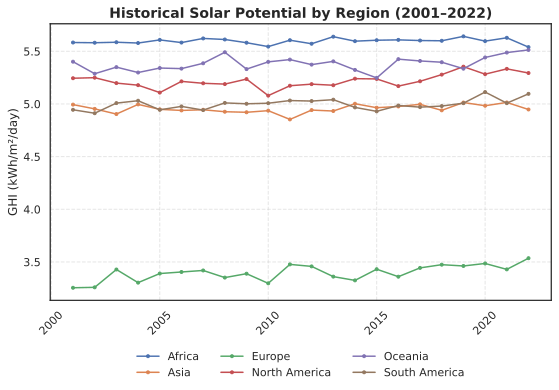

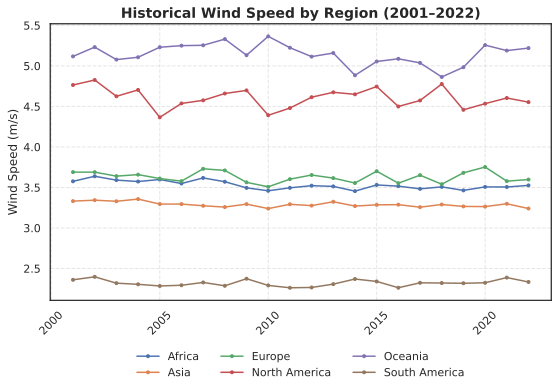

In [20]:
def styled_trend_plot(df, title, ylabel):
    for i, region in enumerate(df.columns):
        plt.plot(df.index, df[region], marker='.', label=region)
    plt.title(title, fontsize = 14, weight = "bold")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
               ncol=3, frameon=False)
    plt.grid(True, linestyle = "--", alpha = 0.5)
    plt.show()

styled_trend_plot(solar_df, "Historical Solar Potential by Region (2001–2022)", "GHI (kWh/m²/day)")
styled_trend_plot(wind_df, "Historical Wind Speed by Region (2001–2022)", "Wind Speed (m/s)")

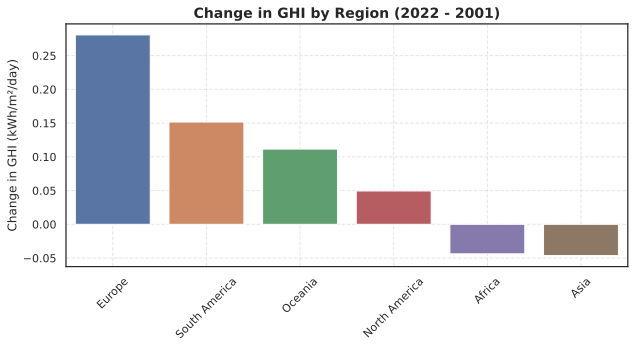

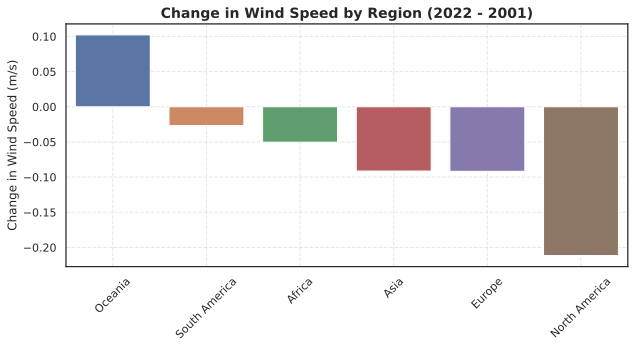

In [21]:
years = list(range(2001, 2023))
months_map = {"JAN": "01", "FEB": "02", "MAR": "03", "APR": "04", "MAY": "05", "JUN": "06",
              "JUL": "07", "AUG": "08", "SEP": "09", "OCT": "10", "NOV": "11", "DEC": "12"}

with open("coords_cache.json") as f:
    coords_data = json.load(f)
with open("nasa_cache_historical.json") as f:
    nasa_data = json.load(f)

region_solar = {r: [] for r in region_mapping}
region_wind = {r: [] for r in region_mapping}

for region, countries in region_mapping.items():
    for code in countries:
        coords = coords_data.get(code)
        if not coords:
            continue
        lat, lon = round(coords["lat"], 4), round(coords["lon"], 4)
        key = f"{lat:.4f}_{lon:.4f}_ALLSKY_SFC_SW_DWN_WS10M"
        if key not in nasa_data:
            continue
        try:
            props = nasa_data[key]["properties"]["parameter"]
            ghi = props["ALLSKY_SFC_SW_DWN"]
            wind = props["WS10M"]
            ghi_delta = np.mean([ghi[f"2022{str(m).zfill(2)}"] - ghi[f"2001{str(m).zfill(2)}"] for m in range(1, 13)])
            wind_delta = np.mean([wind[f"2022{str(m).zfill(2)}"] - wind[f"2001{str(m).zfill(2)}"] for m in range(1, 13)])
            region_solar[region].append(ghi_delta)
            region_wind[region].append(wind_delta)
        except:
            continue
delta_solar = {r: np.mean(v) for r, v in region_solar.items() if v}
delta_wind = {r: np.mean(v) for r, v in region_wind.items() if v}

delta_solar_sorted = dict(sorted(delta_solar.items(), key=lambda x: x[1], reverse=True))
delta_wind_sorted = dict(sorted(delta_wind.items(), key=lambda x: x[1], reverse=True))

regions_solar = list(delta_solar_sorted.keys())
values_solar = list(delta_solar_sorted.values())
regions_wind = list(delta_wind_sorted.keys())
values_wind = list(delta_wind_sorted.values())

solar_df = pd.DataFrame({
    "Region": list(delta_solar_sorted.keys()),
    "Delta": list(delta_solar_sorted.values())
})

wind_df = pd.DataFrame({
    "Region": list(delta_wind_sorted.keys()),
    "Delta": list(delta_wind_sorted.values())
})

sns.barplot(data=solar_df, x="Region", y="Delta", hue="Region", legend=False)
plt.title("Change in GHI by Region (2022 - 2001)", fontsize=14, weight='bold')
plt.ylabel("Change in GHI (kWh/m²/day)")
plt.xlabel("")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

sns.barplot(data=wind_df, x="Region", y="Delta", hue="Region", legend=False)
plt.title("Change in Wind Speed by Region (2022 - 2001)", fontsize=14, weight='bold')
plt.ylabel("Change in Wind Speed (m/s)")
plt.xlabel("")
plt.xticks(rotation=45)
plt.grid(True, linestyle = "--", alpha = 0.5)
plt.tight_layout()
plt.show()

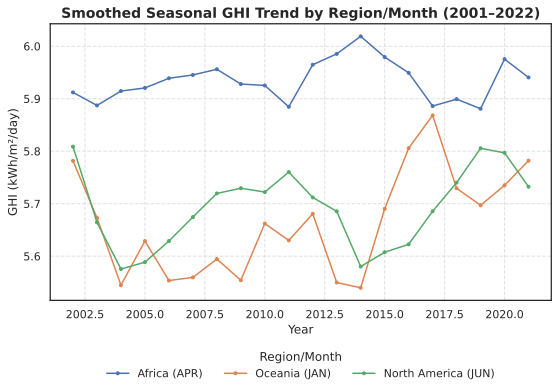

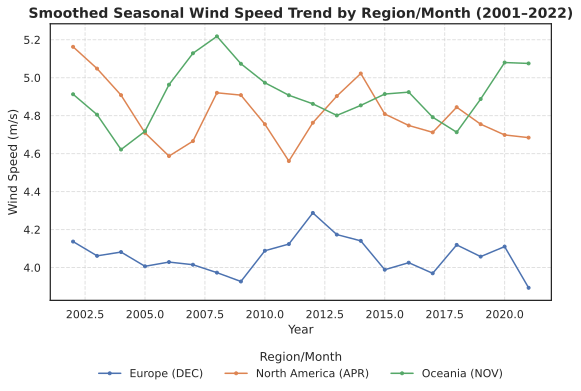

In [22]:
def seasonal_trend(regions_dict, param_key, title, ylabel, smooth_window=3):
    trend_data = {}

    for region, month_name in regions_dict.items():
        month_code = months_map[month_name]
        yearly_vals = []

        for code in region_mapping.get(region, []):
            coords = coords_data.get(code)
            if not coords:
                continue
            lat, lon = round(coords["lat"], 4), round(coords["lon"], 4)
            key = f"{lat:.4f}_{lon:.4f}_ALLSKY_SFC_SW_DWN_WS10M"
            if key not in nasa_data:
                continue
            try:
                data = nasa_data[key]["properties"]["parameter"][param_key]
                vals = [data[f"{year}{month_code}"] for year in years]
                yearly_vals.append(vals)
            except:
                continue

        if yearly_vals:
            smoothed = pd.Series(np.mean(yearly_vals, axis=0)).rolling(window=smooth_window, center=True).mean()
            trend_data[region + f" ({month_name})"] = smoothed

    for label, smooth in trend_data.items():
        plt.plot(years, smooth, marker='.', label=label)

    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.legend(title="Region/Month", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


# GHI
seasonal_trend(
    {"Africa": "APR", "Oceania": "JAN", "North America": "JUN"},
    "ALLSKY_SFC_SW_DWN",
    "Smoothed Seasonal GHI Trend by Region/Month (2001–2022)",
    "GHI (kWh/m²/day)"
)

# Wind
seasonal_trend(
    {"Europe": "DEC", "North America": "APR", "Oceania": "NOV"},
    "WS10M",
    "Smoothed Seasonal Wind Speed Trend by Region/Month (2001–2022)",
    "Wind Speed (m/s)"
)

## **7. How have the costs of different renewable energy sources evolved over the past decades?**

The chart shows renewable energy costs steadily dropping over recent years, particularly solar photovoltaic, which has experienced the sharpest decrease due to advances in technology and growing production scale. Onshore wind energy also shows substantial cost reductions, though somewhat less pronounced. Offshore wind and concentrated solar power have gradually become cheaper, but their decreases are more modest. Bioenergy and hydropower costs have remained mostly stable, with slight variations but no clear downward trend. Taken together, these patterns indicate renewable sources, especially solar and wind, are now more affordable, suggesting they're becoming practical alternatives on a global scale.

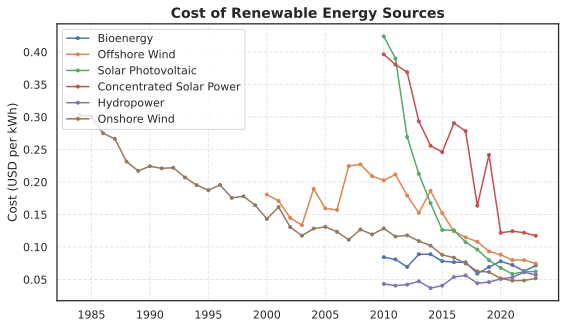

In [23]:
df = pd.read_csv("https://ourworldindata.org/grapher/levelized-cost-of-energy.csv?v=1&csvType=full&useColumnShortNames=true",
                 storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

df = df.groupby("Year").mean(numeric_only = True)
df = df.drop(columns = ["geothermal"])

custom_labels = [
    "Bioenergy",
    "Offshore Wind",
    "Solar Photovoltaic",
    "Concentrated Solar Power",
    "Hydropower",
    "Onshore Wind"
]

for column, label in zip(df.columns, custom_labels):
    plt.plot(df.index, df[column], marker = ".", label = label)

plt.title("Cost of Renewable Energy Sources", fontsize = 14, weight = "bold")
plt.ylabel("Cost (USD per kWh)")
plt.grid(True, linestyle = "--", alpha = 0.5)
plt.legend()

plt.show()

## **8. How has the global share of electricity generation from fossil fuels, renewables, and nuclear energy changed over time?**

Over the past several decades, fossil fuels have consistently accounted for the largest share of global electricity generation. However, the data reveals a gradual but noticeable decline in their dominance, particularly over the last ten to fifteen years. While still comprising the majority, fossil fuel-based electricity has been slowly giving way to cleaner alternatives. In contrast, renewable energy sources have shown a steady and continuous rise in their share of global electricity generation. This upward trend is a clear indicator of the world’s increasing commitment to sustainable and environmentally friendly energy systems. Nuclear energy, meanwhile, has maintained a relatively stable share throughout the same period. It has neither expanded significantly nor diminished, suggesting that its role in the global energy mix remains constant, possibly due to political, economic, and safety concerns. Overall, the figure suggests that while fossil fuels still dominate, the global energy landscape is gradually shifting. Renewables are growing at a slow but consistent pace, indicating progress toward a cleaner energy future, though the transition remains incremental rather than rapid.

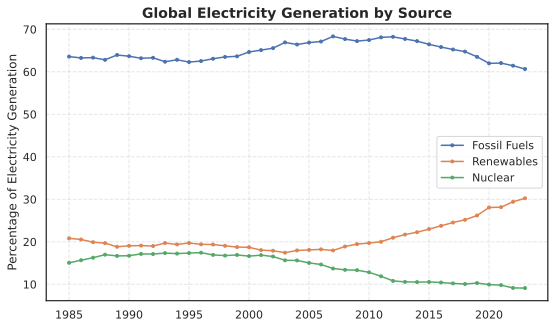

In [24]:
df = pd.read_csv("https://ourworldindata.org/grapher/electricity-fossil-renewables-nuclear-line.csv?v=1&csvType=full&useColumnShortNames=true",
                 storage_options = {"User-Agent": "Our World In Data data fetch/1.0"})

world_data = df[df["Entity"] == "World"]

plt.plot(world_data["Year"], world_data["fossil_share_of_electricity__pct"], label = "Fossil Fuels", marker = ".")
plt.plot(world_data["Year"], world_data["renewable_share_of_electricity__pct"], label = "Renewables", marker = ".")
plt.plot(world_data["Year"], world_data["nuclear_share_of_electricity__pct"], label = "Nuclear", marker = ".")

plt.ylabel("Percentage of Electricity Generation")
plt.title("Global Electricity Generation by Source", fontsize = 14, weight = "bold")
plt.legend()
plt.grid(True, linestyle = "--", alpha = 0.5)

plt.show()

## **9. Which sectors contribute the most to global greenhouse gas emissions?**

The stacked bar chart illustrates global greenhouse gas (GHG) emissions by sector between 1990 and 2021. It clearly identifies electricity and heat production as the dominant source of emissions, followed by transport, manufacturing, and agriculture. These four sectors account for the majority of global GHG output, with electricity and heat alone contributing more than 30% in recent years.

While emissions from sectors like aviation, shipping, and waste remain relatively small, they have shown slow but steady increases over time. Notably, land use change and forestry, though less prominent in absolute terms, continues to play a crucial role, especially in developing economies.

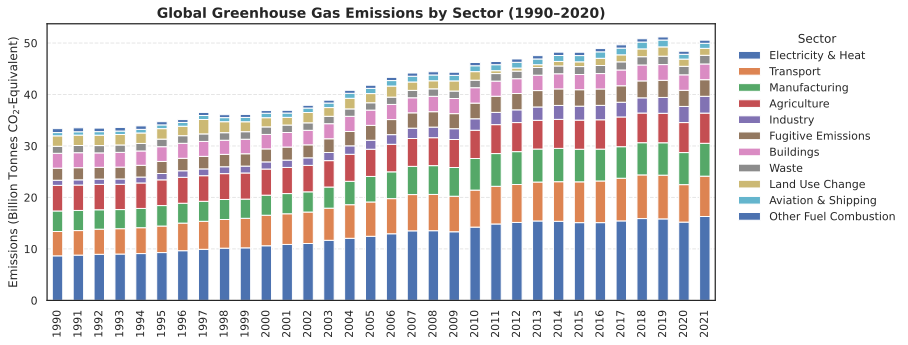

In [25]:
df = pd.read_csv(
    "https://ourworldindata.org/grapher/ghg-emissions-by-sector.csv?v=1&csvType=full&useColumnShortNames=true",
    storage_options={'User-Agent': 'Our World In Data data fetch/1.0'}
)

df_world = df[df["Entity"] == "World"].copy()

columns = {
    "agriculture_ghg_emissions": "Agriculture",
    "land_use_change_and_forestry_ghg_emissions": "Land Use Change",
    "waste_ghg_emissions": "Waste",
    "buildings_ghg_emissions": "Buildings",
    "industry_ghg_emissions": "Industry",
    "manufacturing_and_construction_ghg_emissions": "Manufacturing",
    "transport_ghg_emissions": "Transport",
    "electricity_and_heat_ghg_emissions": "Electricity & Heat",
    "fugitive_ghg_emissions": "Fugitive Emissions",
    "other_fuel_combustion_ghg_emissions": "Other Fuel Combustion",
    "aviation_and_shipping_ghg_emissions": "Aviation & Shipping"
}

df_sector = df_world[["Year"] + list(columns.keys())].rename(columns=columns)
df_sector = df_sector.set_index("Year").dropna()

# Sort sectors by value
last_year = df_sector.index.max()
totals_2020 = df_sector.loc[last_year]
sorted_columns = totals_2020.sort_values(ascending=False).index.tolist()
df_sector_sorted = df_sector[sorted_columns]

df_sector_sorted.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 5)
)

plt.title("Global Greenhouse Gas Emissions by Sector (1990–2020)", fontsize=14, weight='bold')
plt.ylabel("Emissions (Billion Tonnes CO$_2$-Equivalent)")
plt.xlabel("")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-9:.0f}'))

# Sorted legend
handles, labels = plt.gca().get_legend_handles_labels()
sorted_legend = sorted(zip(labels, handles), key=lambda x: totals_2020[x[0]], reverse=True)
sorted_labels, sorted_handles = zip(*sorted_legend)
plt.legend(sorted_handles, sorted_labels, title="Sector", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.show()

## **10. Which regions and countries contribute the most to global CO₂ emissions?**

The visualization highlights that the vast majority of global CO₂ emissions come from a small group of major regions and countries. China has become the single largest emitter since the early 2000s, showing a steep increase linked to industrial growth. The United States maintains a high and historically dominant position, although its emissions have stabilized or slightly declined in recent decades.

Europe has seen a slow decline in emissions over time, especially compared to the global trend. India shows a strong upward trend, now surpassing many developed regions. Emissions from the Middle East and Asia (excluding China and India) have also risen steadily, driven by growing energy demand.

South America and North America (excluding the U.S.) contribute significantly less to global totals but still show growth over time. Together, these eight regions account for over 97% of all global emissions, making them the primary focus for future decarbonization efforts.

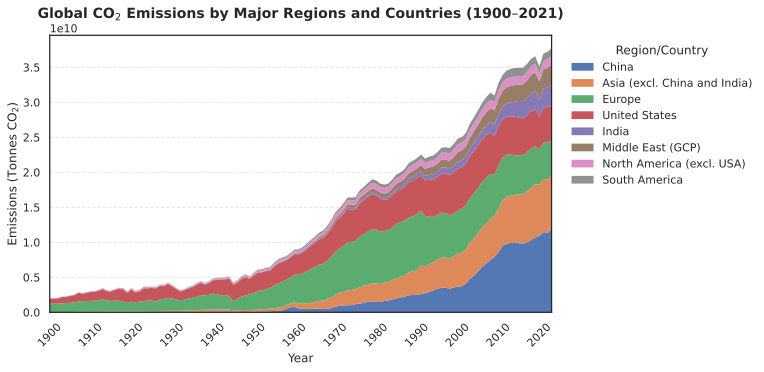

In [26]:
url = "https://ourworldindata.org/grapher/annual-co2-emissions-per-country.csv?v=1&csvType=full&useColumnShortNames=true"
df = pd.read_csv(url, storage_options={'User-Agent': 'Our World In Data data fetch/1.0'})

included_entities = [
    "United States",
    "China",
    "India",
    "Middle East (GCP)",
    "South America",
    "North America (excl. USA)",
    "Asia (excl. China and India)",
    "Europe"
]

df_selected = df[df["Entity"].isin(included_entities) & (df["Year"] >= 1900)].copy()
df_selected["Category"] = df_selected["Entity"]
df_grouped = df_selected.groupby(["Year", "Category"])["emissions_total"].sum().unstack().fillna(0)
final_order = df_grouped.iloc[-1].sort_values(ascending=False).index.tolist()
df_grouped = df_grouped[final_order]

plt.stackplot(df_grouped.index, df_grouped.T.values, labels=final_order, alpha=0.95, linewidth=0)

plt.title("Global CO$_2$ Emissions by Major Regions and Countries (1900–2021)", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Emissions (Tonnes CO$_2$)")
plt.xticks(ticks=range(1900, df_grouped.index.max()+1, 10), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

totals = df_grouped.iloc[-1]
sorted_labels = sorted(final_order, key=lambda x: totals[x], reverse=True)
plt.legend(sorted_labels, title="Region/Country", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.xlim(df_grouped.index.min(), df_grouped.index.max())

plt.show()